In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hydrant.topology.geom as gm
import hydrant.mizuRoute.mizuRoute as mz
import subprocess
import os
from   shapely.geometry import Point

In [2]:
# inputs
path_out = './output/' # were output shapefile, river and mizuRoute network topology will be saved
regions = ['3'] # 3 North America
riv_path = '/project/rpp-kshook/Model_Output/HDMA/processed/'
cat_path = '/project/rpp-kshook/Model_Output/HDMA/processed/'
riv_file_template = 'hdma_global_stream.shp'
cat_file_template = 'hdma_global_catch_v2_*000000.gpkg'

In [3]:
if not os.path.isdir(path_out):
    os.makedirs(path_out)

# Load and append the pfaf

In [4]:
riv, cat = gm.hdma_read_file  (regions,
                               riv_path,
                               riv_file_template,
                               cat_path,
                               cat_file_template)

# prepare the network topology

In [5]:
riv, cat = gm.prepare_ntopo(riv=riv,\
                            riv_cols={'id':'seg_id', 'next_id':'Tosegment'},\
                            cat=cat,\
                            cat_cols={'id':'hruid', 'hillslope':'hillslope', 'area': 'area_org'},\
                            network = 'hdma')

/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:361: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['latitude'] = cat.centroid.y
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:362: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['longitude'] = cat.centroid.x


# Example-1 From Fraser River

In [6]:
# set the case name
prefix = 'Fraser_hdma_'

In [7]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'hruid'},\
                                       riv=riv,\
                                       riv_cols={'id':'seg_id', 'next_id':'Tosegment'},\
                                       outlet_id=[3044523]) # segment that is aimed to make the subbasin for

<Axes: >

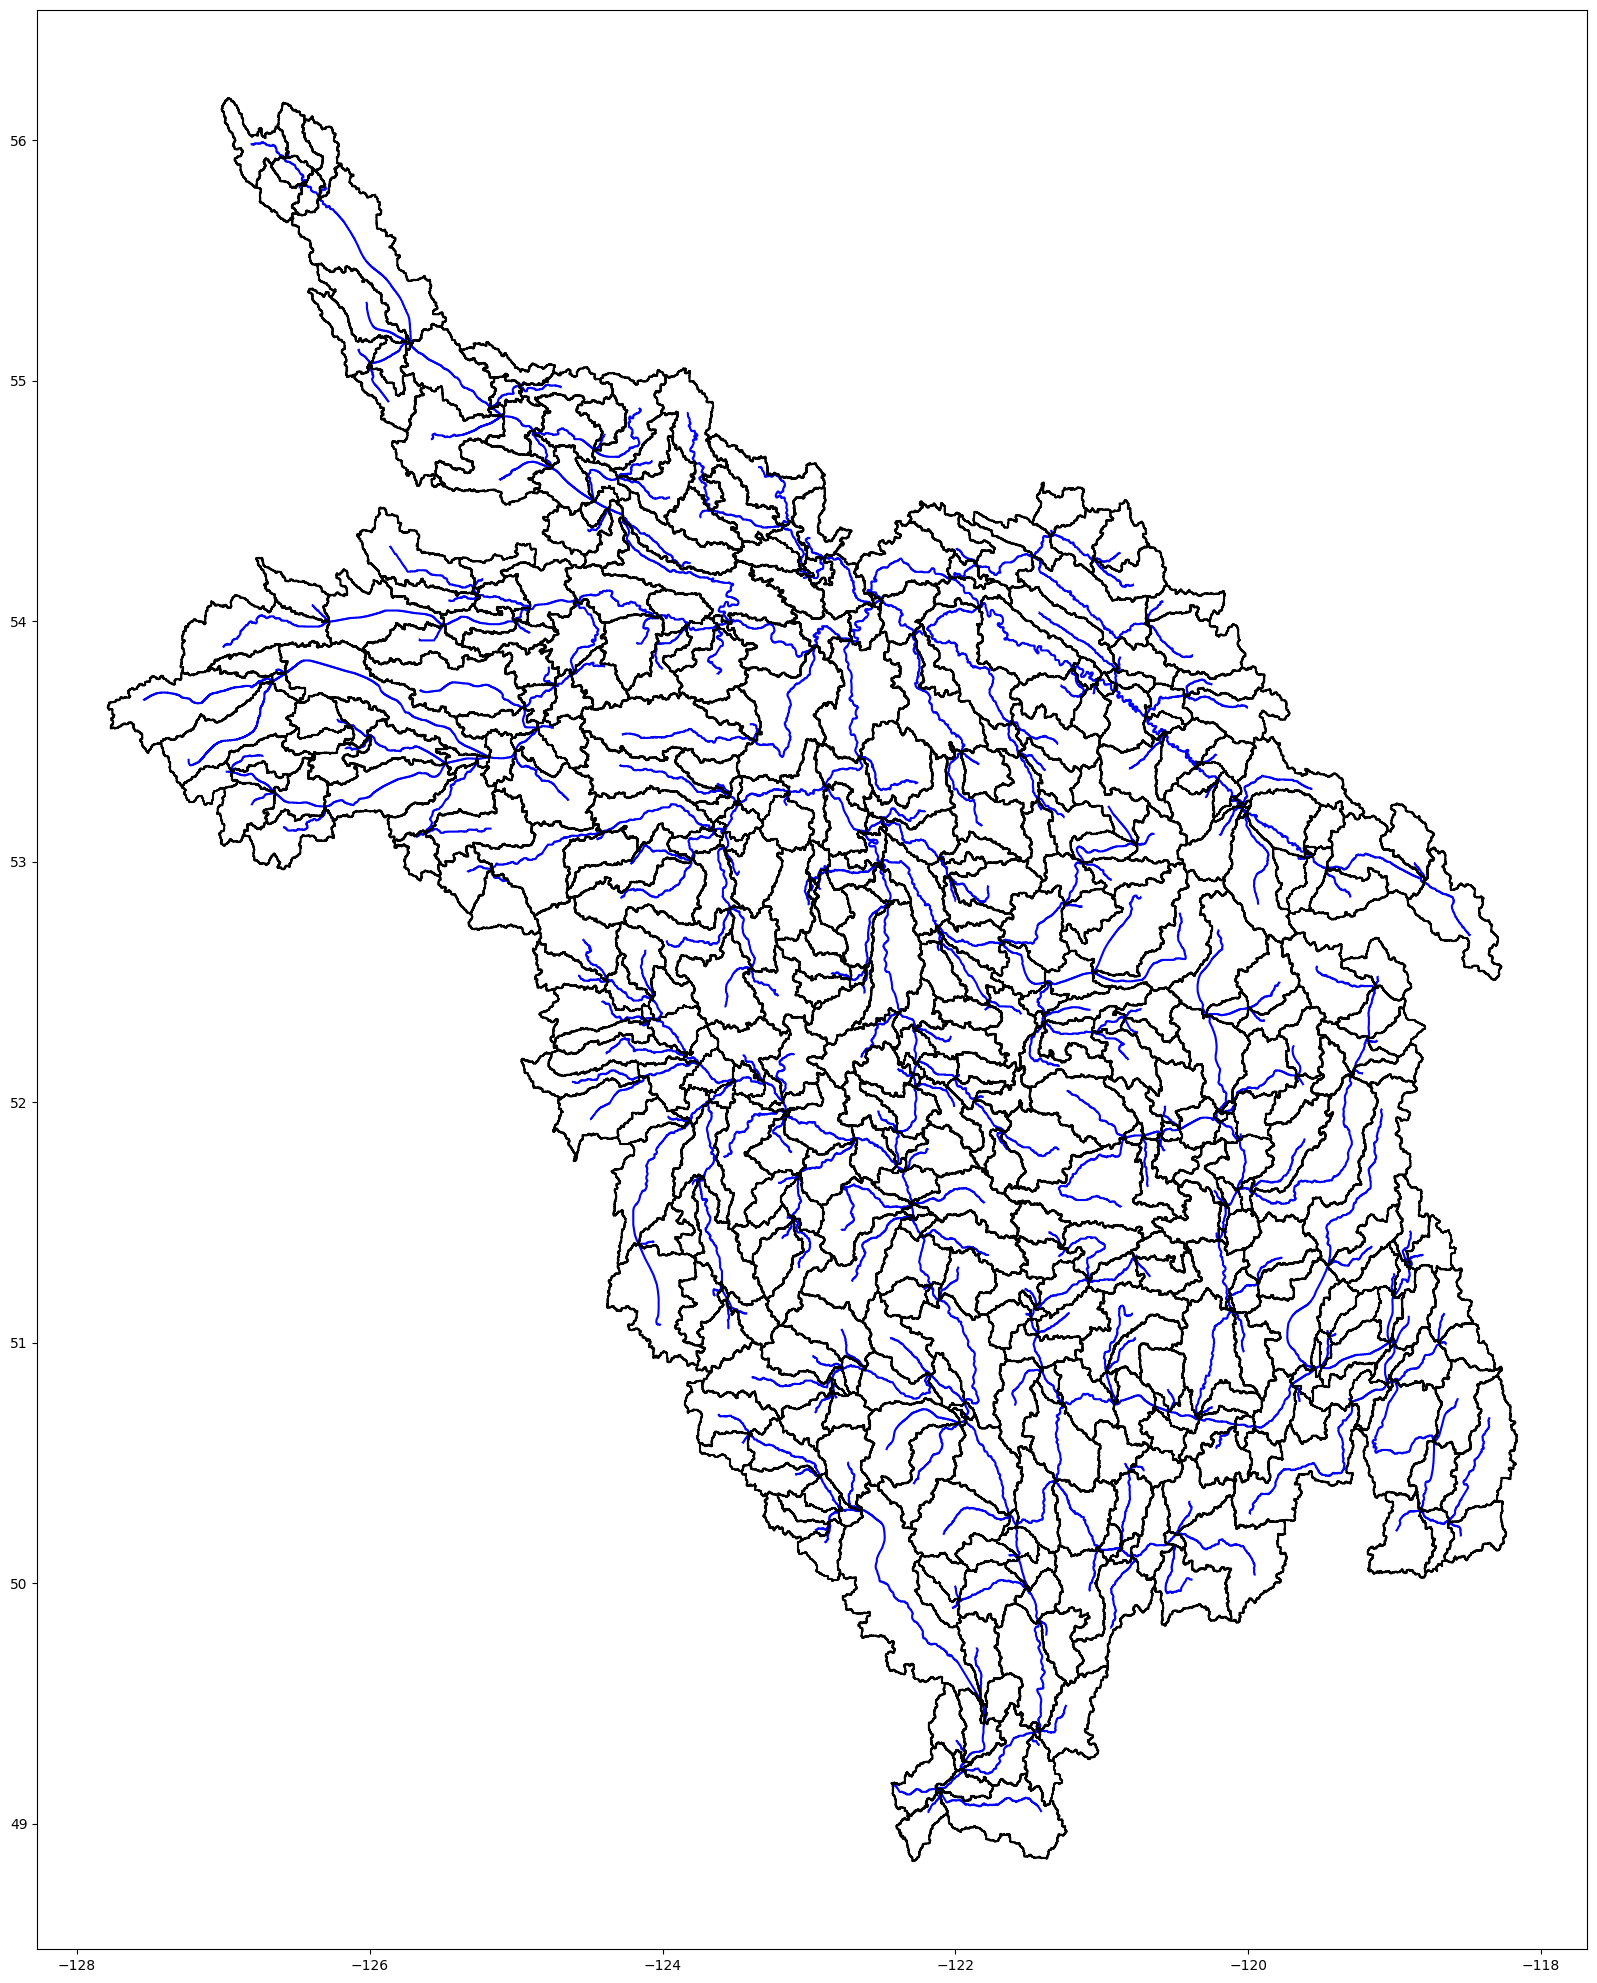

In [8]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')

In [9]:
mz_ntopo = mz.create_nc_ntopo(riv_slice,
                              cat_slice,
                              network = 'hdma')
mz_ntopo

<xarray.Dataset>
Dimensions:     (n: 491)
Coordinates:
  * n           (n) int64 0 1 2 3 4 5 6 7 8 ... 483 484 485 486 487 488 489 490
Data variables: (12/21)
    BotElev     (n) float64 349.0 890.0 730.0 393.0 ... 29.0 10.0 6.0 6.0
    Length      (n) float64 2.271e+03 832.7 4.497e+03 ... 1.817e+04 3.967e+04
    OBJECTID    (n) int64 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999 -9999
    PFAF        (n) int64 3142614 3145364 3146992 ... 314171 31415 314133
    PFAF_CODE   (n) int64 314261400000 314536400000 ... 314133000000
    PF_TYPE     (n) int64 6 6 6 6 6 7 5 5 5 5 6 6 6 ... 2 2 2 2 2 2 2 2 2 2 2 2
    ...          ...
    start_y     (n) float64 50.64 52.51 53.07 51.46 ... 49.4 49.37 49.22 49.15
    hillslope   (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    area_org    (n) float64 2.483e+08 2.487e+08 ... 2.243e+08 5.092e+08
    latitude    (n) float64 50.54 52.48 53.15 51.47 ... 49.39 49.29 49.15 49.18
    longitude   (n) float64 -119.9 -122.9 -119.5 -120.0 ... -121.7 -121.9 -122.2
    width       (n) float64 16.85 16.86 16.93 16.93 ... 469.0 470.0 479.2 481.4

## save

In [10]:
cat_slice.to_file(path_out+prefix+'cat.shp')
riv_slice.to_file(path_out+prefix+'riv.shp')
mz_ntopo.to_netcdf(path_out+prefix+'mizuRoute_ntopo.nc')


# Example-2 From basins of identified pfafs that intersect with Alberta and Saskatchewan

In [11]:
# set the case name
prefix = 'ALSASK_hdma_'

In [12]:
# load the info and the provience
trg_shp = gpd.read_file('./data/province/provinces.shp')
sel_pr = ['Alberta','Saskatchewan']
# subsetting `provinces` variable
trg_provinces = trg_shp.loc[trg_shp.PRENAME.isin(sel_pr)].copy().to_crs(epsg=4326)

In [13]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'hruid'},\
                                       riv=riv,\
                                       riv_cols={'id':'seg_id', 'next_id':'Tosegment'},\
                                       shapefile=trg_provinces)

<Axes: >

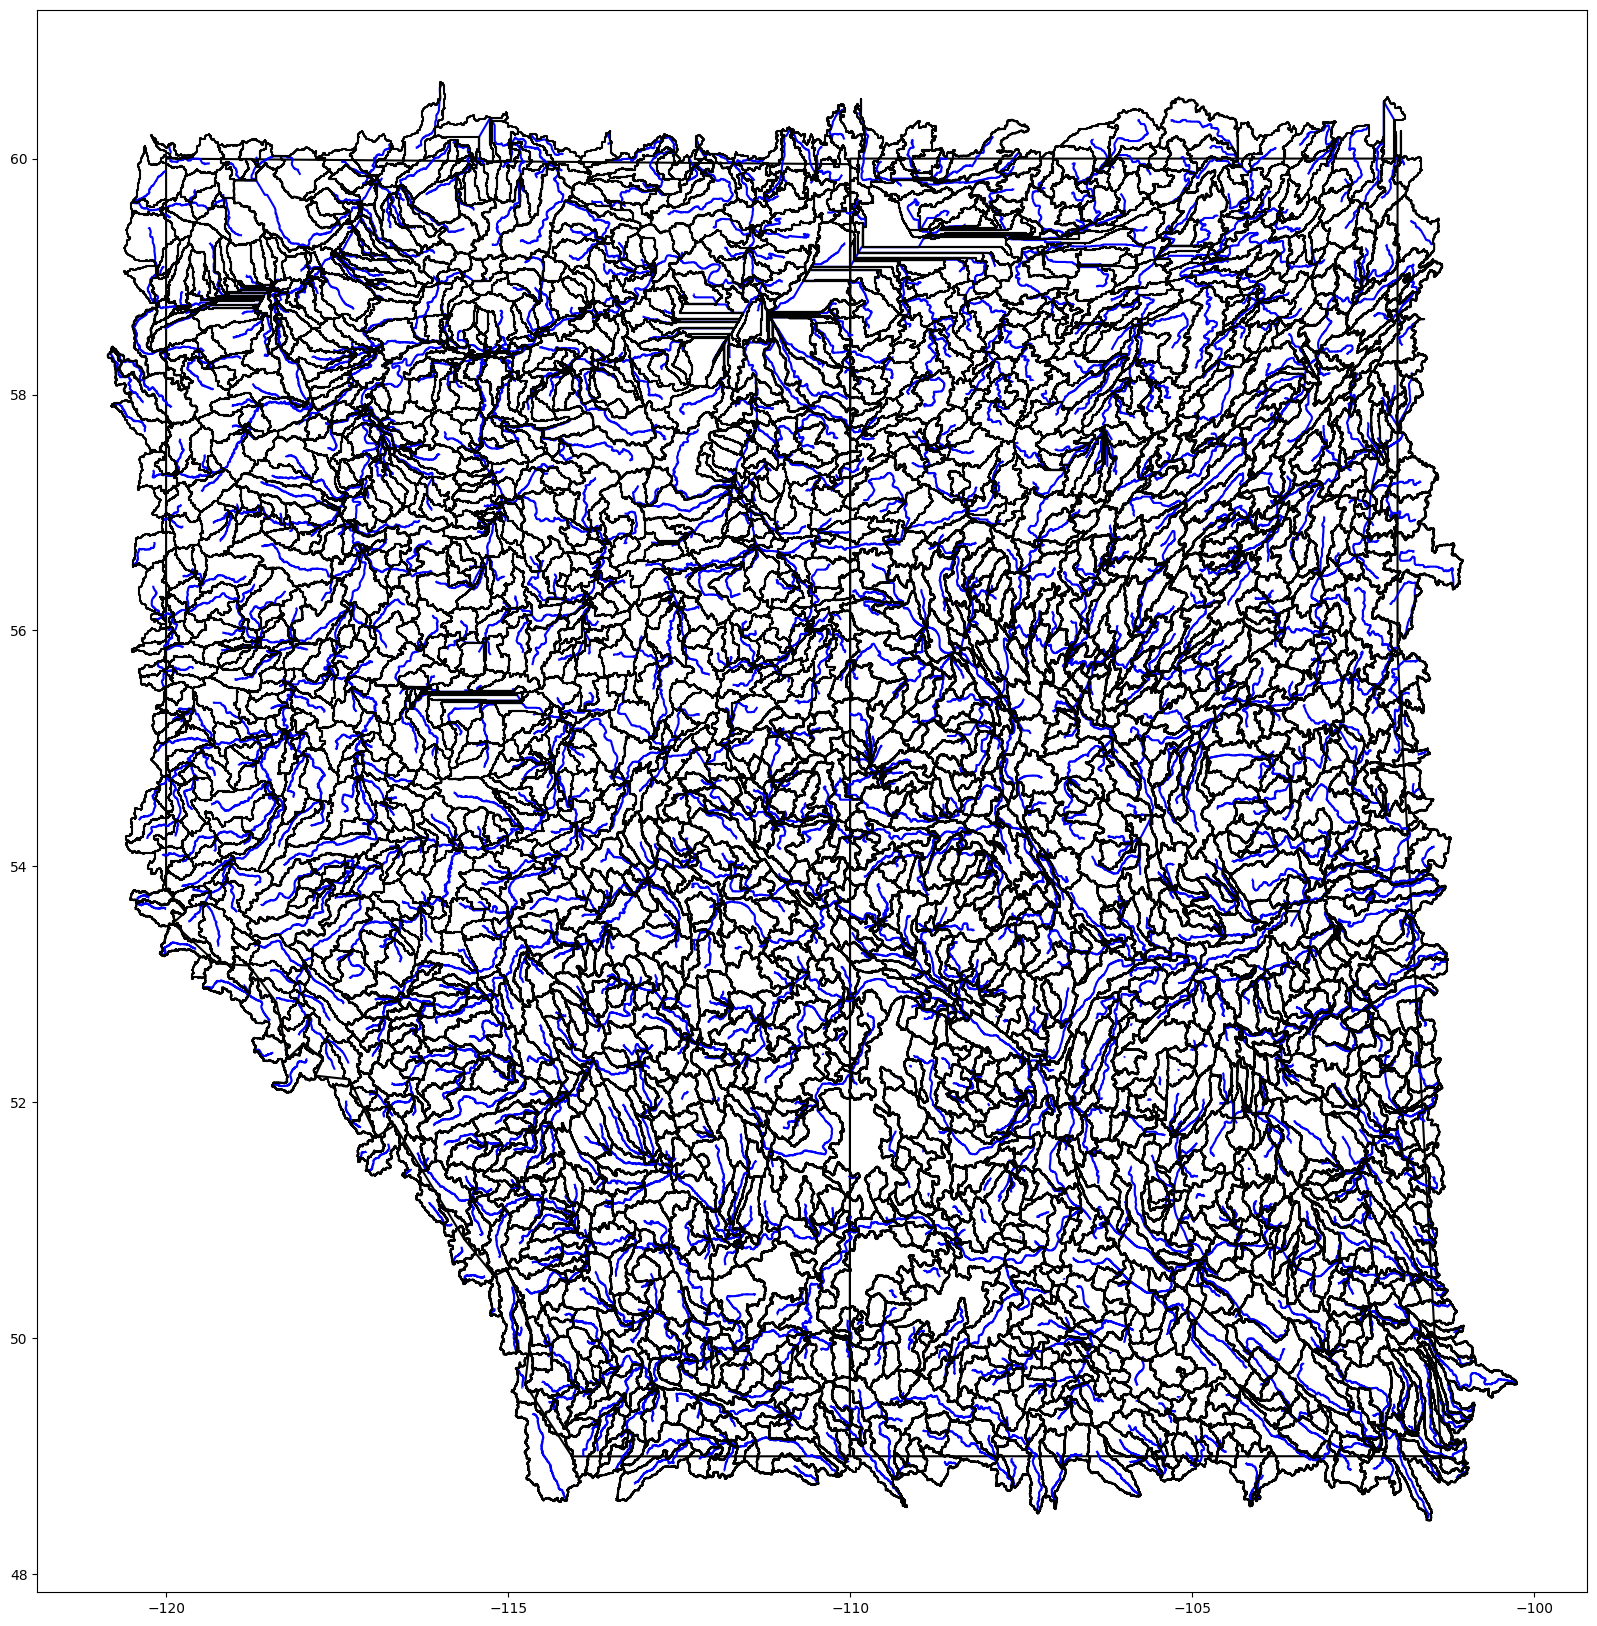

In [14]:
fig, ax = plt.subplots(figsize=(20,30))
trg_provinces.boundary.plot(ax=ax, color='k')
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')

In [15]:
mz_ntopo = mz.create_nc_ntopo(riv_slice,
                              cat_slice,
                              network = 'hdma')
mz_ntopo

<xarray.Dataset>
Dimensions:     (n: 3136)
Coordinates:
  * n           (n) int64 0 1 2 3 4 5 6 7 ... 3129 3130 3131 3132 3133 3134 3135
Data variables: (12/21)
    BotElev     (n) float64 791.0 627.0 561.0 ... -9.999e+03 -9.999e+03
    Length      (n) float64 688.6 347.9 673.2 671.4 ... 1.0 1.0 1.0 1.0
    OBJECTID    (n) int64 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999 -9999
    PFAF        (n) int64 3294244 3426122 3293942 349646 ... -9999 -9999 -9999
    PFAF_CODE   (n) int64 329424400000 342612200000 329394200000 ... -9999 -9999
    PF_TYPE     (n) int64 6 6 6 5 6 5 5 ... -9999 -9999 -9999 -9999 -9999 -9999
    ...          ...
    start_y     (n) float64 54.71 50.99 56.04 ... -9.999e+03 -9.999e+03
    hillslope   (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    area_org    (n) float64 2.462e+08 2.486e+08 2.452e+08 ... 5.018e+08 1.31e+08
    latitude    (n) float64 54.64 51.04 55.93 52.04 ... 49.35 49.26 49.16 49.13
    longitude   (n) float64 -116.2 -110.4 -117.1 -102.9 ... -104.1 -104.2 -107.8
    width       (n) float64 16.81 16.81 16.82 16.82 ... 21.35 5.97 23.4 12.45

In [16]:
cat_slice.to_file(path_out+prefix+'cat.shp')
riv_slice.to_file(path_out+prefix+'riv.shp')
mz_ntopo.to_netcdf(path_out+prefix+'mizuRoute_ntopo.nc')

# Example-3 From basins of identified pfafs that intersect with target stations in Alberta

In [17]:
# set the case name
prefix = 'stations_hdma_'

In [18]:
data = {
    'Station ID': ['05BE004', '05BH004', '05BL004', '05CC002'],
    'seg ID': [3035173, 3037796, 3030143, 3039206],
    'Station name': [
        'BOW RIVER NEAR SEEBE',
        'BOW RIVER AT CALGARY',
        'HIGHWOOD RIVER BELOW LITTLE BOW CANAL',
        'RED DEER RIVER AT RED DEER'
    ],
    'up': [0, 0, 0, 0],
    'X': [-115.03,-114.05,-113.86,-113.82],
    'Y': [  51.11,  51.05,  50.58,  52.27]
}

# Create a DataFrame from the dictionary
stations_seg_id = pd.DataFrame(data)

# Create a points from the dictionary
geometry = [Point(xy) for xy in zip(data['X'], data['Y'])]
stations_points = gpd.GeoDataFrame(data, geometry=geometry, crs='EPSG:4326')

In [19]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'hruid'},\
                                       riv=riv,\
                                       riv_cols={'id':'seg_id', 'next_id':'Tosegment'},\
                                       outlet_id=list(stations_seg_id['seg ID']))



<Axes: >

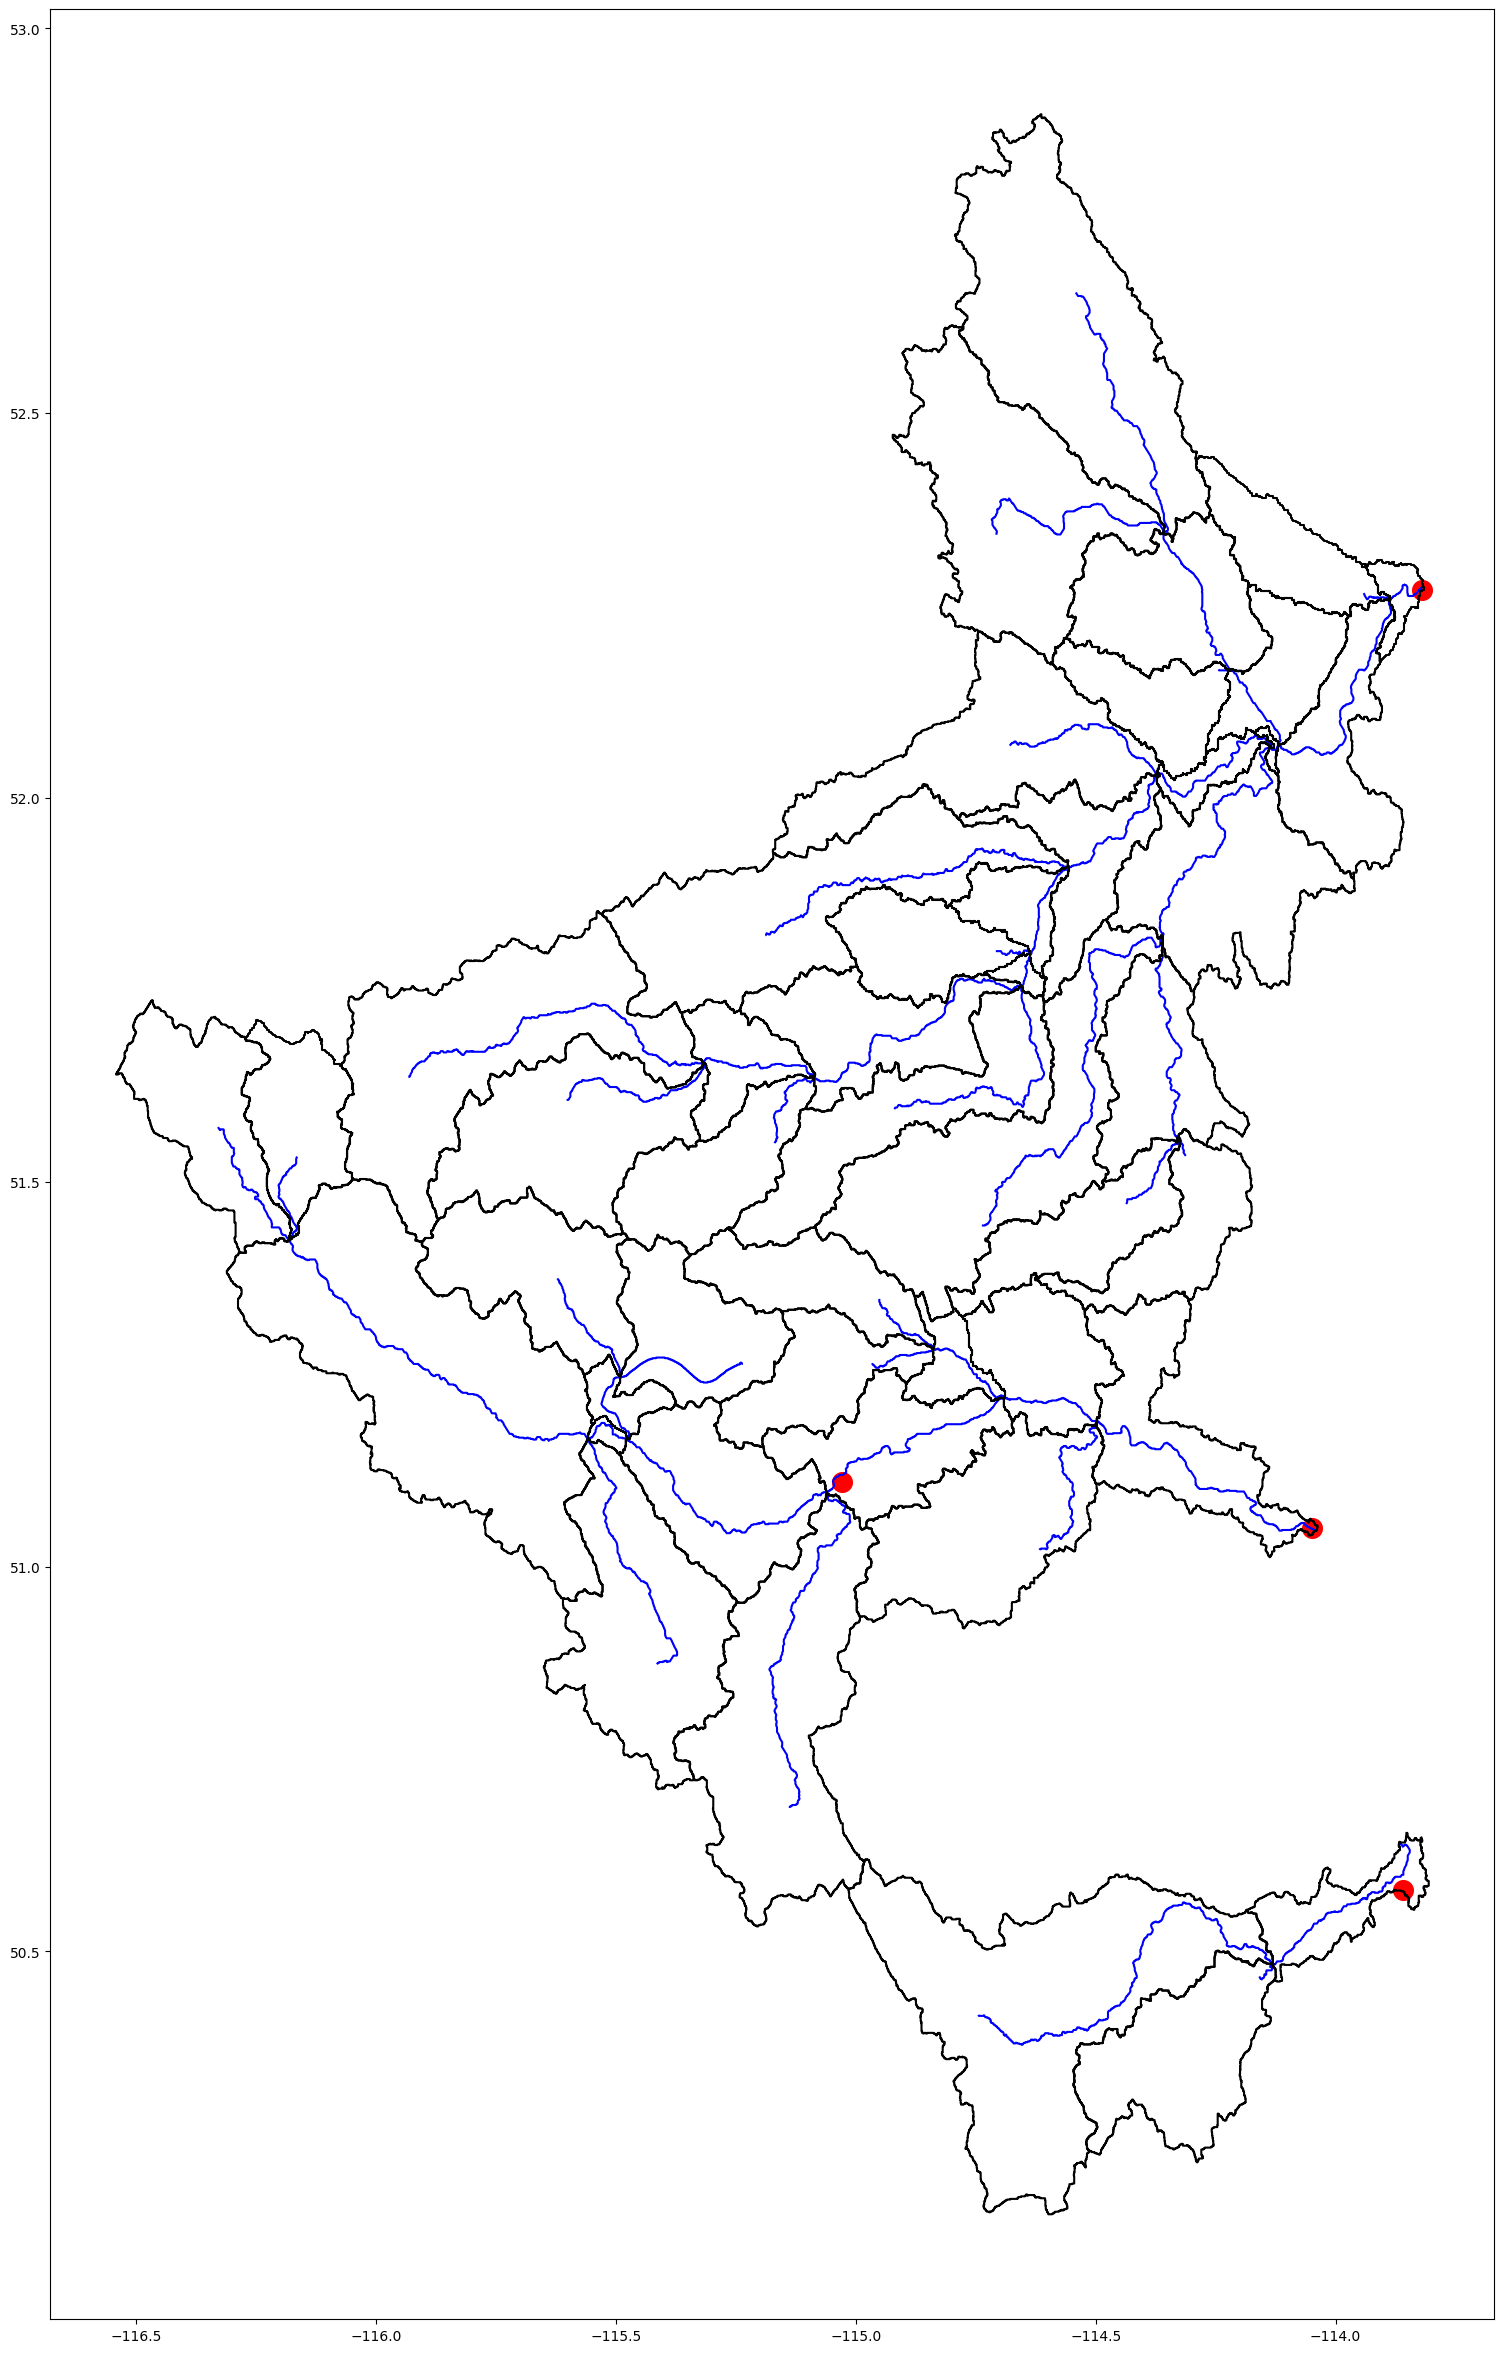

In [20]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')
stations_points.plot(ax=ax, color='r', markersize=200)


In [21]:
mz_ntopo = mz.create_nc_ntopo(riv_slice,
                              cat_slice,
                              network = 'hdma')
mz_ntopo

<xarray.Dataset>
Dimensions:     (n: 47)
Coordinates:
  * n           (n) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45 46
Data variables: (12/21)
    BotElev     (n) float64 903.0 857.0 1.09e+03 1.065e+03 ... 891.0 857.0 849.0
    Length      (n) float64 2.229e+03 7.085e+03 ... 4.416e+04 9.113e+03
    OBJECTID    (n) int64 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999 -9999
    PFAF        (n) int64 342662 3426594 3426952 ... 34267 3426595 3426593
    PFAF_CODE   (n) int64 342662000000 342659400000 ... 342659300000
    PF_TYPE     (n) int64 5 6 6 5 6 6 5 4 6 6 3 5 5 ... 3 3 3 3 3 3 3 3 3 3 3 3
    ...          ...
    start_y     (n) float64 52.17 52.27 51.8 51.53 ... 51.19 52.06 52.07 52.26
    hillslope   (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    area_org    (n) float64 2.512e+08 2.551e+08 2.83e+08 ... 3.678e+08 5.211e+07
    latitude    (n) float64 52.13 52.32 51.81 51.43 ... 51.18 52.06 52.05 52.26
    longitude   (n) float64 -114.4 -114.1 -114.9 -114.3 ... -114.1 -114.0 -113.9
    width       (n) float64 16.87 17.03 17.97 18.2 ... 90.36 91.77 108.1 109.6

In [22]:
cat_slice.to_file(path_out+prefix+'cat.shp')
riv_slice.to_file(path_out+prefix+'riv.shp')
mz_ntopo.to_netcdf(path_out+prefix+'mizuRoute_ntopo.nc')